# OnOff Map Fit

In [215]:
import pytest
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.cube import (
    MapDataset,
    MapDatasetOnOff,
    MapDatasetMaker,
    PSFKernel,
    SafeMaskMaker,
)
from gammapy.data import GTI
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    BackgroundModel,
    GaussianSpatialModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
)
from gammapy.data import DataStore


In [217]:
# A fit with OnOff Maps
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
o1 = 23559 #Crab run
obs_on = datastore.obs(o1)
o2 = 23736 #Off run at high zenith angle
obs_off = datastore.obs(o2)



In [227]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
ebounds = np.logspace(-0.5, 1.0, 10)
axis = MapAxis.from_edges(ebounds, name="energy", unit=u.TeV, interp="log")
geom_on =  WcsGeom.create(
        skydir=target_position,
        binsz=0.02,
        width=(2, 2),
        axes=[axis],
)

spectral = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
spatial = PointSpatialModel(lon_0="83.63 deg", lat_0="22.01 deg", frame="icrs")
spatial.parameters['lon_0'].frozen = False
spatial.parameters['lat_0'].frozen = False

model = SkyModel(spatial, spectral)


In [228]:

maker_obs = MapDatasetMaker(offset_max=2.0 * u.deg, cutout=False)
safe_mask_maker = SafeMaskMaker(methods=["offset-max"], offset_max="2 deg")

empty = MapDataset.create(geom=geom_on)
dataset_on = maker_obs.run(empty, obs_on, selection=["counts", "exposure", "background"])

geom_off = WcsGeom.create(
    skydir=obs_off.pointing_radec,
    binsz=0.02,
    width=(2, 2),
    axes=[axis],
)
empty = MapDataset.create(geom=geom_off)
dataset_off = maker_obs.run(empty, obs_off, selection=["counts", "exposure"])


Choice of the acceptance is tricky.
1. We need to pass maps having the same geom
2. The `on` and `off` observations must be at the same conditions

Here, I am using the two livetimes, but it may not be ideal.
What will be ideal is to use the "source free" region counts - pu a 

In [229]:
alpha_off = dataset_on.counts.copy(data=np.ones(dataset_off.counts.data.shape)*obs_off.observation_live_time_duration.value)
alpha_on = dataset_on.counts.copy(data=np.ones(dataset_on.counts.data.shape)*obs_on.observation_live_time_duration.value)



In [230]:
dataset_onoff = MapDatasetOnOff(model=model,
                                    counts=dataset_on.counts,
                                    counts_off=dataset_off.counts,
                                    acceptance=alpha_on,
                                    acceptance_off=alpha_off,
                                    exposure=dataset_on.exposure,
                                    gti=dataset_on.gti,
                                    )

dataset_onoff = safe_mask_maker.run(dataset_onoff, obs_on)

In [231]:
print(dataset_onoff)

MapDatasetOnOff

    Name                            :  

    Total counts                    : 1494 
    Total predicted counts          : 110.08
    Total background counts         : nan

    Exposure min                    : 1.30e+04 m2 s
    Exposure max                    : 8.83e+08 m2 s

    Number of total bins            : 90000 
    Number of fit bins              : 63369 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3643.19

    Number of models                : 1 
    Number of parameters            : 5
    Number of free parameters       : 4

    Component 0: 
        Name                        : source
        Type                        : SkyModel
        Spatial  model type         : PointSpatialModel
        Spectral model type         : PowerLawSpectralModel
        Parameters:
        

    Total counts_off                : 1736 
    Acceptance                      : 142031117 
    Acceptance off                  : 143691390 



In [232]:
fit = Fit([dataset_onoff])
result = fit.run(optimize_opts={"print_level": 5})

------------------------------------------------------------------
| FCN = 3506                    |     Ncalls=259 (259 total)     |
| EDM = 0.000103 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


In [233]:
print(dataset_onoff)

MapDatasetOnOff

    Name                            :  

    Total counts                    : 1494 
    Total predicted counts          : 9.54
    Total background counts         : nan

    Exposure min                    : 1.30e+04 m2 s
    Exposure max                    : 8.83e+08 m2 s

    Number of total bins            : 90000 
    Number of fit bins              : 63369 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3505.96

    Number of models                : 1 
    Number of parameters            : 5
    Number of free parameters       : 4

    Component 0: 
        Name                        : source
        Type                        : SkyModel
        Spatial  model type         : PointSpatialModel
        Spectral model type         : PowerLawSpectralModel
        Parameters:
        

    Total counts_off                : 1736 
    Acceptance                      : 142031117 
    Acceptance off                  : 143691390 



In [234]:
print(model)


SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 8.363e+01   nan            deg        nan       nan  False
    lat_0 2.201e+01   nan            deg -9.000e+01 9.000e+01  False
    index 3.547e+00   nan                       nan       nan  False
amplitude 1.686e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True


In [235]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,8.363e+01,4.053e-03,deg,nan,nan,False
lat_0,2.201e+01,3.826e-03,deg,-9.000e+01,9.000e+01,False
index,3.547e+00,9.852e-01,,nan,nan,False
amplitude,1.686e-12,1.088e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [236]:
print(obs_off)

Info for OBS_ID = 23736
- Start time: 53373.80
- Pointing pos: RA 83.87 deg / Dec -69.77 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 5.304 %



In [237]:
obs_off.pointing_radec

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86775208, -69.77027893)>

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1289cd0f0>)

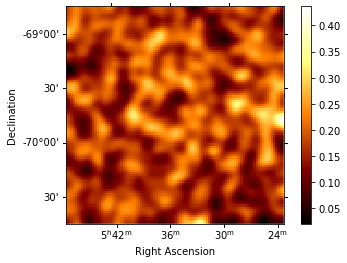

In [238]:
dataset_off.counts.sum_over_axes().smooth(0.05*u.deg).plot(add_cbar=True)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x128f79780>)

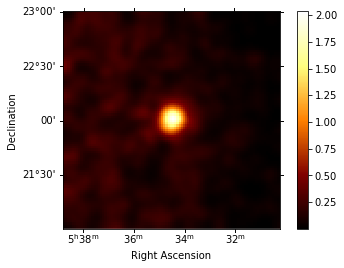

In [239]:
dataset_on.counts.sum_over_axes().smooth(0.05*u.deg).plot(add_cbar=True)